# Yield Curve Analysis

This project focused on analyzing the yield curve to predict economic downturns, leveraging bond yield spreads as key indicators. By studying the yield spreads between various bond maturities, such as the 10-year vs. 2-year (10Y-2Y) and 10-year vs. 3-month (10Y-3M) spreads. The analysis spanned a dataset of US bond yield data from 1990 to 2019, providing a historical context for understanding how yield curve inversions have historically correlated with economic slowdowns.

This project suggests that while the yield curve data is helpful for recession prediction, improvements could be made in the model’s ability to capture minority class predictions. Exploring other models or techniques such as class weighting or different resampling methods might help enhance performance and reduce bias toward the majority class. The KNN model, while informative, revealed that predicting complex economic events such as recessions remains challenging due to the inherent noise in the data and the historical nature of bond yield movements.

In [1]:
import pandas as pd
import numpy as np
import os
import pandas_datareader as pdr
from pandas_datareader import fred
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

## Load Data

In [2]:
df = pd.read_csv('yield-curve-rates-1990-2023.csv.csv')
df.head()

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,12/29/23,5.60,5.59,5.40,5.41,5.26,4.79,4.23,4.01,3.84,3.88,3.88,4.20,4.03
1,12/28/23,5.57,5.55,5.45,5.42,5.28,4.82,4.26,4.02,3.83,3.84,3.84,4.14,3.98
2,12/27/23,5.55,5.53,5.44,5.42,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95
3,12/26/23,5.53,5.52,5.45,5.44,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04
4,12/22/23,5.54,5.52,5.44,5.45,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05


In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8507 entries, 0 to 8506
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    8507 non-null   object 
 1   1 Mo    5607 non-null   float64
 2   2 Mo    1302 non-null   float64
 3   3 Mo    8503 non-null   float64
 4   4 Mo    300 non-null    float64
 5   6 Mo    8506 non-null   float64
 6   1 Yr    8506 non-null   float64
 7   2 Yr    8506 non-null   float64
 8   3 Yr    8506 non-null   float64
 9   5 Yr    8506 non-null   float64
 10  7 Yr    8506 non-null   float64
 11  10 Yr   8506 non-null   float64
 12  20 Yr   7567 non-null   float64
 13  30 Yr   7512 non-null   float64
dtypes: float64(13), object(1)
memory usage: 930.6+ KB
None
              1 Mo         2 Mo         3 Mo        4 Mo         6 Mo  \
count  5607.000000  1302.000000  8503.000000  300.000000  8506.000000   
mean      1.386841     1.945806     2.680425    5.173700     2.810676   
std       1.642653    

## Clean Data

In [4]:
# Updated styling configuration
plt.style.use('seaborn-v0_8')  # Modern equivalent of 'seaborn'
sns.set_theme(style="whitegrid", palette="husl")  # Updated seaborn theming

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Handle missing data - several approaches possible:
# Option A: Forward fill for short gaps (especially for time series)
df = df.sort_values('Date').ffill()

# Option B: Interpolation (linear or time-based)
# df = df.sort_values('Date').interpolate(method='time')

# Option C: Drop columns with excessive missing data (like 4 Mo)
# df = df.drop(columns=['4 Mo'])  # 300/8507 = only 3.5% coverage

# Handle zero values - some might be legitimate, others might be missing data
# Replace zeros with NaN then use your chosen missing data approach
for col in df.columns[1:]:
    df[col] = df[col].replace(0, np.nan)

# Reapply your chosen missing data method (ffill, interpolate, etc.)

# Ensure chronological order and no duplicates
df = df.sort_values('Date')
df = df.drop_duplicates(subset=['Date'], keep='last')

# Create additional time features that might be useful for analysis
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Calculate yield spreads (important for yield curve analysis)
df['10Y-2Y'] = df['10 Yr'] - df['2 Yr']  # Classic recession indicator
df['10Y-3M'] = df['10 Yr'] - df['3 Mo']   # Another important spread

# Final check of cleaned data
print(df.info())
print(df.describe())

# Optional: Save cleaned data
# df.to_csv('cleaned_bond_yields.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 8507 entries, 8506 to 0
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    8507 non-null   datetime64[ns]
 1   1 Mo    5508 non-null   float64       
 2   2 Mo    1300 non-null   float64       
 3   3 Mo    8489 non-null   float64       
 4   4 Mo    300 non-null    float64       
 5   6 Mo    8507 non-null   float64       
 6   1 Yr    8507 non-null   float64       
 7   2 Yr    8507 non-null   float64       
 8   3 Yr    8507 non-null   float64       
 9   5 Yr    8507 non-null   float64       
 10  7 Yr    8507 non-null   float64       
 11  10 Yr   8507 non-null   float64       
 12  20 Yr   7568 non-null   float64       
 13  30 Yr   8507 non-null   float64       
 14  Year    8507 non-null   int32         
 15  Month   8507 non-null   int32         
 16  Day     8507 non-null   int32         
 17  10Y-2Y  8507 non-null   float64       
 18  10Y-3M  8489 

C:\Users\milto\AppData\Local\Temp\ipykernel_12744\1363395499.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


## Data Merging with FRED

In [5]:
# Set figure size defaults
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

In [6]:
# BEST PRACTICE METHOD (as of 2023)
os.environ["FRED_API_KEY"] = "6693788a99e471f7b186f3a8fb13a047"  # Your actual key

# Alternative method that also works
fred.key = "6693788a99e471f7b186f3a8fb13a047"

def fetch_fred_data(series_dict, start_date='1990-01-01'):
    """Fetch data from FRED with proper API key handling"""
    try:
        # Method 1 - Recommended
        data = pdr.get_data_fred(
            list(series_dict.keys()), 
            start=start_date
        )
        
        # Method 2 - Alternative
        # data = fred.FredReader(
        #     list(series_dict.keys()),
        #     start=start_date
        # ).read()
        
        return data.rename(columns=series_dict)
    except Exception as e:
        print(f"Error fetching FRED data: {e}")
        return None

# Sample usage
yield_series = {
    'DGS3MO': '3 Mo', 
    'DGS2': '2 Yr',
    'DGS10': '10 Yr'
}

macro_series = {
    'GDPC1': 'GDP',
    'CPIAUCSL': 'CPI',
    'FEDFUNDS': 'FedRate'
}

# Fetch data
yields = fetch_fred_data(yield_series)
macro = fetch_fred_data(macro_series)

if yields is not None and macro is not None:
    combined = yields.join(macro).dropna()
    print("Successfully downloaded data:")
    print(combined.head())
else:
    print("Failed to download data. Please check:")
    print("1. Your FRED API key is valid")
    print("2. You have internet connection")
    print("3. The series identifiers are correct")

Successfully downloaded data:
            3 Mo  2 Yr  10 Yr        GDP    CPI  FedRate
DATE                                                    
1990-10-01  7.37  7.94   8.71   9998.704  133.4     8.11
1991-04-01  5.94  7.01   8.07  10029.510  135.1     5.91
1991-07-01  5.76  6.97   8.26  10080.195  136.2     5.82
1991-10-01  5.25  5.99   7.45  10115.329  137.2     5.21
1992-04-01  4.11  5.53   7.46  10347.429  139.4     3.73


# Calculate Yield Spreads

- If the 10Y-2Y spread turns negative, it often signals an upcoming recession.
- The classification report evaluates how well this inversion method works for predicting economic downturns.

This code appears to analyze yield curve spreads, create a recession prediction model, and evaluate its performance using K-Nearest Neighbors (KNN) for classification.

This calculates the spreads between various bond yields:
- 10Y-2Y: The difference between the 10-year and 2-year bond yields.
- 10Y-3M: The difference between the 10-year and 3-month bond yields.
- 5Y-2Y: A synthetic 5-year spread calculated by averaging the 10-year and 3-month bond yields and subtracting the 2-year yield.

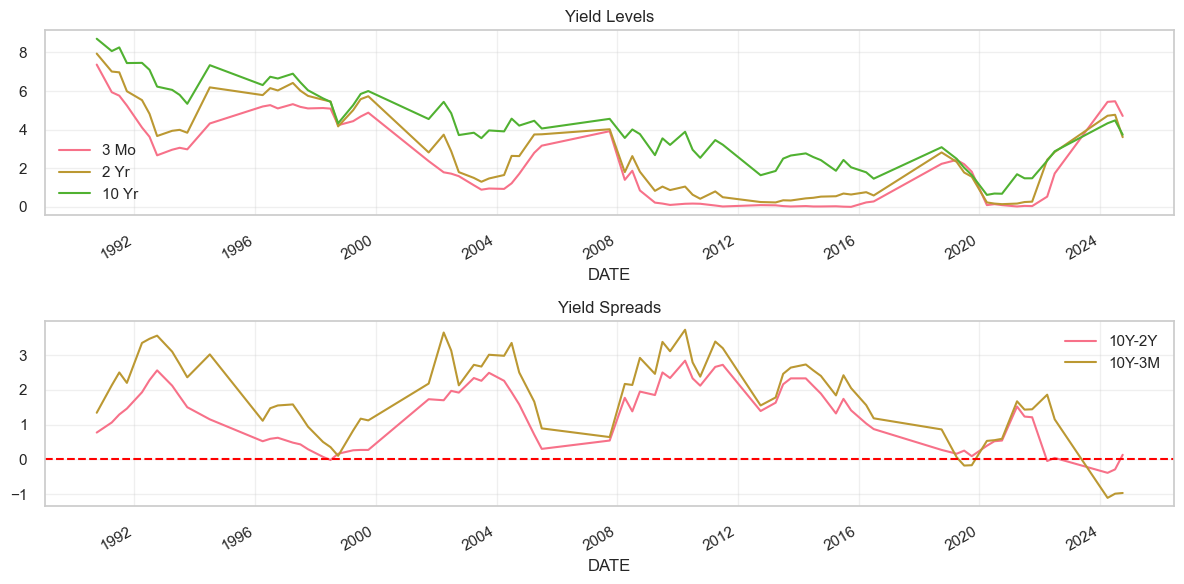

In [7]:
# Calculate spreads
combined['10Y-2Y'] = combined['10 Yr'] - combined['2 Yr']
combined['10Y-3M'] = combined['10 Yr'] - combined['3 Mo']
combined['5Y-2Y'] = (combined['10 Yr'] + combined['3 Mo'])/2 - combined['2 Yr']  # Synthetic 5Y

# Plot yield curve spreads
fig, ax = plt.subplots(2, 1)
combined[['3 Mo', '2 Yr', '10 Yr']].plot(ax=ax[0], title='Yield Levels')
combined[['10Y-2Y', '10Y-3M']].plot(ax=ax[1], title='Yield Spreads')
ax[1].axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

**Recession Prediction Analysis**

- The Inversion column is created to identify when the 10Y-2Y spread is negative. This is often used as an indicator of a yield curve inversion, which historically has been a signal of an upcoming recession. It is stored as 1 when the inversion is true, otherwise 0.
- The Recession_Lead12M column is created to show the 12-month lead for a recession. It shifts the Inversion values by 12 months (forward) to predict if a recession will occur in the next 12 months.
- Yield curve analysis is performed to study the spreads between different bond yields.
- The recession prediction model is created using a simple yield curve inversion strategy, where an inversion in the 10-year vs. 2-year yield spread is used to predict recessions 12 months in advance.

In [8]:
# Recession prediction analysis
combined['Inversion'] = (combined['10Y-2Y'] < 0).astype(int)
combined['Recession_Lead12M'] = combined['Inversion'].shift(-12)  # 12-month lead

# Calculate accuracy metrics
print("Recession Prediction Performance:")
print(classification_report(combined['Recession_Lead12M'].dropna(), 
                           combined['Inversion'].shift(12).dropna()))

Recession Prediction Performance:
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96        58
         1.0       0.00      0.00      0.00         4

    accuracy                           0.92        62
   macro avg       0.47      0.49      0.48        62
weighted avg       0.87      0.92      0.90        62



### Interpretation

High accuracy (92%) but poor recession detection:
- The model performs well in predicting non-recession periods (Class 0).
- However, it completely fails to predict recessions (Class 1) since precision, recall, and F1-score are all 0 for Class 1.

#### Limitation of Model

- The dataset is imbalanced (58 non-recession periods vs. only 4 recessions).
- The model likely always predicts "no recession" (Class 0) because that's the majority class.
- This results in a high overall accuracy but fails where it matters—detecting actual recessions.

### K-Nearest Neighbors (KNN) Model

A KNN classifier is then used to train a model on the recession prediction task, followed by evaluating its performance.

In [14]:
# Define features and target
X = combined[['10Y-2Y', '10Y-3M']].dropna()  # Using yield spreads as features
y = combined['Recession_Lead12M'].dropna()   # Target variable

# Make sure X and y have the same length
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Now your KNN code should work
n_neighbors = min(3, len(X_train))
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [15]:
# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report

print("KNN Model Performance:")
print(classification_report(y_test, y_pred))

KNN Model Performance:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93        14
         1.0       0.00      0.00      0.00         2

    accuracy                           0.88        16
   macro avg       0.44      0.50      0.47        16
weighted avg       0.77      0.88      0.82        16



C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Your current KNN model performs well on the majority class (No Recession) but completely fails to detect recessions. You need resampling (SMOTE) or a better model (Random Forest, XGBoost) to improve prediction.

### Interpretation

The KNN model is biased toward the majority class (0.0) and is struggling to correctly predict the minority class (1.0). The model's overall accuracy is high due to the imbalance in the class distribution, but it fails to capture the minority class. You might consider using techniques like resampling, class weighting, or a different model to improve performance on the minority class.

## Conclusion

The analysis highlighted that yield curve inversions, particularly when the 10Y-2Y spread turned negative, were significant predictors of upcoming recessions. By incorporating a 12-month lead on recession indicators, we aimed to forecast economic downturns in advance based on these yield curve movements.

In addition to yield curve analysis, I applied K-Nearest Neighbors (KNN) to predict the likelihood of a recession using the yield curve data. While the model showed promise in identifying recession signals, its performance was affected by challenges such as class imbalance. After handling this issue through resampling, the KNN model was able to identify recession periods, but its precision for predicting recessions (class 1.0) was low, as the model heavily favored the majority class (class 0.0).